# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [173]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。

np.random.seed(1234) #这里有变化，仅需要设置numpy的随机数生成器的种子。设置随机数生成器的种子可以确保每次运行程序时，NumPy生成的随机数序列都是一样的。

# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [174]:
# import deepxde as dde #deepxde是一个用于求解深度学习中的微分方程的库
import numpy as np
import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

In [175]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [176]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out

In [177]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)

        
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
        
        #print the loss        
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e' % (self.iter, loss.item()) #
            ) #每100次迭代，打印一次迭代次数、总的loss、loss_u和loss_f
        return loss #返回总的loss
    
    def train(self, nIter):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式


        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in range(nIter):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights

        #     #print the loss
        #     if epoch % 100 == 0:
        #         print(
        #             'It: %d, Loss: %.3e' % 
        #             (
        #                 epoch, 
        #                 loss
        #             )
        #         )


        #使用Adam优化器优化nIter次
        for epoch in range(nIter):
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights




            #print the loss
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e' % 
                    (
                        epoch, 
                        loss
                    ) #每100次迭代，打印一次迭代次数、总的loss
                )        
        
        
        
        # # 使用LBFGS优化器优化
        # self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
        # print('The total Iter of LBFGS is %d, the final loss is %e' %(self.iter,self.loss_func()))


        return W
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f

In [178]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

def quasirandom(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[0]
        t_min, t_max = space[1]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[0]
        t_min, t_max = space[1]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

## Configurations

In [179]:
nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 1000
#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)

# #生成配位点训练基础数据
# X_f_train = quasirandom(N_f, "LHS")  #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，表示生产的样本有两个特征，共N_f个样本数量，所以返回的是一个形状为（N_f，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本X_f_train。

# X_f_train = np.vstack((X_f_train, X_u_train)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.random.choice(X_u_train_all.shape[0], N_u, replace=False) #从0~数组X_u_train的行数 中随机选择N_u个数，replace=False表示不允许重复选择，最后将这N_u个数赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

## Training

In [180]:
# 定义所有的采样方法
samplers = ["LHS", "Halton", "Hammersley", "Sobol", "Grid", "Random"]

error = []  #创建一个空列表，用于存储误差值
trainloss = [] #创建一个空列表，用于存储训练损失值

# 遍历所有的采样方法
for sampler in samplers:
    # 调用quasirandom函数生成配位点
    X_f_train = quasirandom(N_f, sampler)

    X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train
    
    # 打印样本信息
    print(f"Sampler: {sampler}, Samples: {len(X_f_train)}")


    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(50000)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

    #将误差添加到error列表中
    error.append(error_u)                    


    #将训练损失值添加到trainloss列表中
    trainloss.append(torch.stack(model.loss_value).cpu().detach().numpy())



Sampler: LHS, Samples: 1456
It: 0, Loss: 2.586e-01
It: 100, Loss: 1.317e-01
It: 200, Loss: 9.040e-02
It: 300, Loss: 7.656e-02
It: 400, Loss: 6.402e-02
It: 500, Loss: 5.582e-02
It: 600, Loss: 5.118e-02
It: 700, Loss: 4.676e-02
It: 800, Loss: 4.051e-02
It: 900, Loss: 3.362e-02
It: 1000, Loss: 2.826e-02
It: 1100, Loss: 2.331e-02
It: 1200, Loss: 2.189e-01
It: 1300, Loss: 8.575e-02
It: 1400, Loss: 7.704e-02
It: 1500, Loss: 6.912e-02
It: 1600, Loss: 6.596e-02
It: 1700, Loss: 6.383e-02
It: 1800, Loss: 6.252e-02
It: 1900, Loss: 6.172e-02
It: 2000, Loss: 6.109e-02
It: 2100, Loss: 6.051e-02
It: 2200, Loss: 6.005e-02
It: 2300, Loss: 5.981e-02
It: 2400, Loss: 7.660e-02
It: 2500, Loss: 5.828e-02
It: 2600, Loss: 5.732e-02
It: 2700, Loss: 5.782e-02
It: 2800, Loss: 5.410e-02
It: 2900, Loss: 1.520e-01
It: 3000, Loss: 1.434e-01
It: 3100, Loss: 1.193e-01
It: 3200, Loss: 9.211e-02
It: 3300, Loss: 8.362e-02
It: 3400, Loss: 7.078e-02
It: 3500, Loss: 6.308e-02
It: 3600, Loss: 5.819e-02
It: 3700, Loss: 5.500e

C:\Users\lcy\AppData\Local\Temp\ipykernel_79684\3470741103.py:16: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
c:\Users\lcy\anaconda3\envs\pytorchgpu\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  warnings.warn(


It: 0, Loss: 2.571e-01
It: 100, Loss: 1.546e-01
It: 200, Loss: 9.340e-02
It: 300, Loss: 7.023e-02
It: 400, Loss: 5.538e-02
It: 500, Loss: 4.550e-02
It: 600, Loss: 3.785e-02
It: 700, Loss: 4.415e-02
It: 800, Loss: 3.416e-02
It: 900, Loss: 3.165e-02
It: 1000, Loss: 2.776e-02
It: 1100, Loss: 2.774e-02
It: 1200, Loss: 2.449e-02
It: 1300, Loss: 2.360e-02
It: 1400, Loss: 2.233e-02
It: 1500, Loss: 2.311e-02
It: 1600, Loss: 2.174e-02
It: 1700, Loss: 1.861e-02
It: 1800, Loss: 1.871e-02
It: 1900, Loss: 1.762e-02
It: 2000, Loss: 1.767e-02
It: 2100, Loss: 1.965e-02
It: 2200, Loss: 1.665e-02
It: 2300, Loss: 2.390e-02
It: 2400, Loss: 1.629e-02
It: 2500, Loss: 1.546e-02
It: 2600, Loss: 1.570e-02
It: 2700, Loss: 1.510e-02
It: 2800, Loss: 1.494e-02
It: 2900, Loss: 1.876e-02
It: 3000, Loss: 1.444e-02
It: 3100, Loss: 2.012e-02
It: 3200, Loss: 1.217e-02
It: 3300, Loss: 1.244e-02
It: 3400, Loss: 1.126e-02
It: 3500, Loss: 1.029e-02
It: 3600, Loss: 9.696e-03
It: 3700, Loss: 9.382e-03
It: 3800, Loss: 8.487e-0

In [181]:
# #打印误差随迭代次数的变化
# trainloss = torch.stack(model.loss_value).cpu().detach().numpy()
# # print(trainloss)
# # print(trainloss.shape)
# indices=list(range(len(trainloss)))
# plt.figure()
# plt.plot(indices,trainloss,color='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# # plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([0,max(indices)]) # 设置x轴的范围
# plt.ylim([0,0.2]) # 设置y轴的范围
# plt.show()

## Visualizations

In [182]:
print(len(trainloss))
print(error)
print(trainloss[0])

6
[0.21125949120412216, 0.6056361261267199, 0.7852090699565025, 0.400484329544876, 0.7008635462628756, 0.7531200273467514]
[2.5855911e-01 2.5666970e-01 2.5539008e-01 ... 1.7315376e-04 2.1506529e-04
 2.7133161e-04]


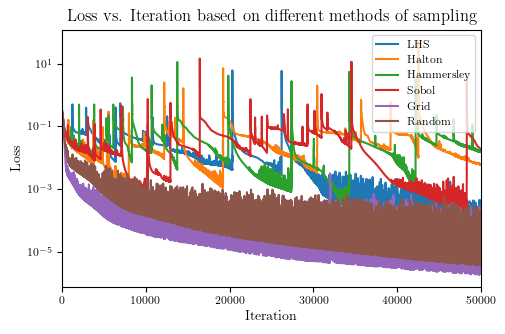

In [184]:
# 定义图例的标签
labels = ["LHS", "Halton", "Hammersley", "Sobol", "Grid", "Random"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例
plt.legend()

plt.xlim([0,50000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

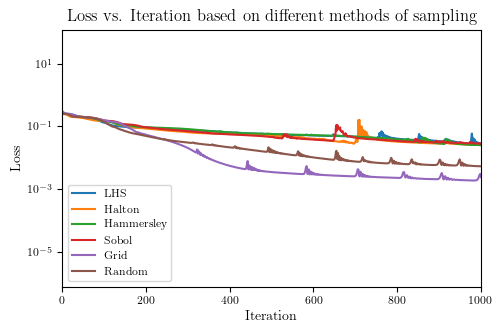

In [186]:
# 定义图例的标签
labels = ["LHS", "Halton", "Hammersley", "Sobol", "Grid", "Random"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for loss, label in zip(trainloss, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(loss, label=label)

# 添加图例
plt.legend()

plt.xlim([0,1000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [213]:
# 定义所有的采样方法
samplers = ["LHS", "Halton", "Hammersley", "Sobol", "Grid", "Random"]

error = []  #创建一个空列表，用于存储误差值

# 遍历所有的采样方法
for sampler in samplers:
    error_sampler = []
    for N in range(100, 102, 1):
    # for N in range(100, 10001, 200):
        # 调用quasirandom函数生成配位点
        X_f_train = quasirandom(N, sampler)

        X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train
        
        # 打印样本信息
        print(f"Sampler: {sampler}, Samples: {len(X_f_train)}")


        #创建PINN模型并输入各种参数     
        model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)

        # #获取当前时间并赋值给start_time  
        # start_time = time.time()   
        #开始训练模型            
        model.train(10000)
        # #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
        # elapsed = time.time() - start_time
        # #打印训练所花时间                
        # print('Training time: %.4f' % (elapsed))

        #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
        u_pred, f_pred = model.predict(X_star)
        #计算误差（基于2范数）        
        error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

        #将误差添加到error列表中
        error_sampler.append(error_u)

    error.append(error_sampler)                    


Sampler: LHS, Samples: 556
It: 0, Loss: 2.602e-01
It: 100, Loss: 1.487e-01
It: 200, Loss: 6.542e-02
It: 300, Loss: 4.285e-02
It: 400, Loss: 3.304e-02
It: 500, Loss: 2.793e-02
It: 600, Loss: 2.431e-02
It: 700, Loss: 2.026e-02
It: 800, Loss: 1.460e-02
It: 900, Loss: 1.114e-02
It: 1000, Loss: 9.057e-03
It: 1100, Loss: 7.836e-03
It: 1200, Loss: 7.576e-03
It: 1300, Loss: 5.620e-03
It: 1400, Loss: 5.776e-03
It: 1500, Loss: 4.540e-03
It: 1600, Loss: 3.930e-03
It: 1700, Loss: 2.943e-03
It: 1800, Loss: 2.309e-03
It: 1900, Loss: 2.142e-03
It: 2000, Loss: 2.399e-03
It: 2100, Loss: 1.679e-03
It: 2200, Loss: 2.019e-03
It: 2300, Loss: 1.693e-03
It: 2400, Loss: 2.260e-03
It: 2500, Loss: 1.384e-03
It: 2600, Loss: 1.587e-03
It: 2700, Loss: 1.250e-03
It: 2800, Loss: 1.367e-03
It: 2900, Loss: 9.898e-04
It: 3000, Loss: 2.160e-03
It: 3100, Loss: 1.283e-03
It: 3200, Loss: 9.144e-04
It: 3300, Loss: 8.101e-04
It: 3400, Loss: 9.618e-04
It: 3500, Loss: 8.726e-04
It: 3600, Loss: 7.641e-04
It: 3700, Loss: 9.874e-

C:\Users\lcy\AppData\Local\Temp\ipykernel_79684\3470741103.py:16: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
c:\Users\lcy\anaconda3\envs\pytorchgpu\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+102=102. 
  warnings.warn(


Sampler: Sobol, Samples: 556
It: 0, Loss: 2.553e-01
It: 100, Loss: 1.397e-01
It: 200, Loss: 6.970e-02
It: 300, Loss: 5.072e-02
It: 400, Loss: 3.801e-02
It: 500, Loss: 2.799e-02
It: 600, Loss: 2.072e-02
It: 700, Loss: 1.773e-02
It: 800, Loss: 1.273e-02
It: 900, Loss: 8.216e-03
It: 1000, Loss: 6.075e-03
It: 1100, Loss: 5.210e-03
It: 1200, Loss: 5.591e-03
It: 1300, Loss: 4.600e-03
It: 1400, Loss: 5.763e-03
It: 1500, Loss: 4.753e-03
It: 1600, Loss: 4.534e-03
It: 1700, Loss: 3.790e-03
It: 1800, Loss: 3.398e-03
It: 1900, Loss: 3.517e-03
It: 2000, Loss: 3.011e-03
It: 2100, Loss: 5.701e-03
It: 2200, Loss: 4.380e-03
It: 2300, Loss: 2.621e-03
It: 2400, Loss: 4.476e-03
It: 2500, Loss: 2.411e-03
It: 2600, Loss: 2.233e-03
It: 2700, Loss: 2.135e-03
It: 2800, Loss: 3.687e-03
It: 2900, Loss: 1.684e-03
It: 3000, Loss: 1.874e-03
It: 3100, Loss: 1.927e-03
It: 3200, Loss: 1.402e-03
It: 3300, Loss: 1.766e-03
It: 3400, Loss: 1.178e-03
It: 3500, Loss: 1.276e-03
It: 3600, Loss: 1.440e-03
It: 3700, Loss: 1.153

C:\Users\lcy\AppData\Local\Temp\ipykernel_79684\3470741103.py:16: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
c:\Users\lcy\anaconda3\envs\pytorchgpu\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn(


Sampler: Sobol, Samples: 557
It: 0, Loss: 3.225e-01
It: 100, Loss: 1.451e-01
It: 200, Loss: 6.998e-02
It: 300, Loss: 5.055e-02
It: 400, Loss: 3.791e-02
It: 500, Loss: 3.243e-02
It: 600, Loss: 2.737e-02
It: 700, Loss: 2.052e-02
It: 800, Loss: 1.775e-02
It: 900, Loss: 1.684e-02
It: 1000, Loss: 1.730e-02
It: 1100, Loss: 1.548e-02
It: 1200, Loss: 1.044e-02
It: 1300, Loss: 1.020e-02
It: 1400, Loss: 9.207e-03
It: 1500, Loss: 8.803e-03
It: 1600, Loss: 8.223e-03
It: 1700, Loss: 7.696e-03
It: 1800, Loss: 7.613e-03
It: 1900, Loss: 7.467e-03
It: 2000, Loss: 7.156e-03
It: 2100, Loss: 7.688e-03
It: 2200, Loss: 7.263e-03
It: 2300, Loss: 7.234e-03
It: 2400, Loss: 6.572e-03
It: 2500, Loss: 6.630e-03
It: 2600, Loss: 6.291e-03
It: 2700, Loss: 6.140e-03
It: 2800, Loss: 5.980e-03
It: 2900, Loss: 5.792e-03
It: 3000, Loss: 5.523e-03
It: 3100, Loss: 3.981e-03
It: 3200, Loss: 2.337e-03
It: 3300, Loss: 1.783e-03
It: 3400, Loss: 3.112e-03
It: 3500, Loss: 1.006e-03
It: 3600, Loss: 8.936e-04
It: 3700, Loss: 9.740

In [216]:
print(len(error))
print(error)
print(error_sampler)
print(len(error_sampler))

6
[[0.2867572846110833, 0.3008035643748712], [0.2799185392689535, 0.28028439339188116], [0.4982187991209644, 0.24166236120039433], [0.240392519520323, 0.21245166017485112], [0.8916616287372927, 0.7291237526510527], [0.9440127546541295, 0.5696679774740999]]
[0.9440127546541295, 0.5696679774740999]
2


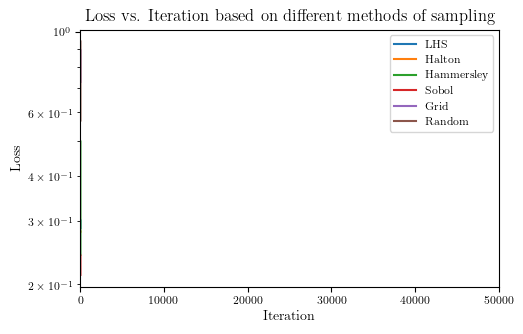

In [215]:
# 定义图例的标签
labels = ["LHS", "Halton", "Hammersley", "Sobol", "Grid", "Random"]

# 创建一个新的图形
plt.figure()

# 遍历所有的loss数据和标签
for er, label in zip(error, labels):
    # 绘制每个loss数据，并使用标签作为图例的条目
    plt.plot(er, label=label)

# 添加图例
plt.legend()

plt.xlim([0,50000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()